# Data Wrangling

Because this dataset comes from a Kaggle competition, the data is already well formatted and requires very little wrangling. Instead, this section of the project will center on how to read and format the data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors


import os 
import json
from pathlib import Path

In [2]:
# %load prettyjson.py
# Used to print json objects into a more readable format. Taken from https://github.com/andy-gh/prettyjson
# https://stackoverflow.com/a/56497521/104668

def prettyjson(obj, indent=2, maxlinelength=80):
    """Renders JSON content with indentation and line splits/concatenations to fit maxlinelength.
    Only dicts, lists and basic types are supported"""

    items, _ = getsubitems(obj, itemkey="", islast=True, maxlinelength=maxlinelength - indent, indent=indent)
    return indentitems(items, indent, level=0)


def getsubitems(obj, itemkey, islast, maxlinelength, indent):
    items = []
    is_inline = True      # at first, assume we can concatenate the inner tokens into one line

    isdict = isinstance(obj, dict)
    islist = isinstance(obj, list)
    istuple = isinstance(obj, tuple)
    isbasictype = not (isdict or islist or istuple)

    maxlinelength = max(0, maxlinelength)

    # build json content as a list of strings or child lists
    if isbasictype:
        # render basic type
        keyseparator  = "" if itemkey == "" else ": "
        itemseparator = "" if islast else ","
        items.append(itemkey + keyseparator + basictype2str(obj) + itemseparator)

    else:
        # render lists/dicts/tuples
        if isdict:    opening, closing, keys = ("{", "}", iter(obj.keys()))
        elif islist:  opening, closing, keys = ("[", "]", range(0, len(obj)))
        elif istuple: opening, closing, keys = ("[", "]", range(0, len(obj)))    # tuples are converted into json arrays

        if itemkey != "": opening = itemkey + ": " + opening
        if not islast: closing += ","

        count = 0
        itemkey = ""
        subitems = []

        # get the list of inner tokens
        for (i, k) in enumerate(keys):
            islast_ = i == len(obj)-1
            itemkey_ = ""
            if isdict: itemkey_ = basictype2str(k)
            inner, is_inner_inline = getsubitems(obj[k], itemkey_, islast_, maxlinelength - indent, indent)
            subitems.extend(inner)                        # inner can be a string or a list
            is_inline = is_inline and is_inner_inline     # if a child couldn't be rendered inline, then we are not able either

        # fit inner tokens into one or multiple lines, each no longer than maxlinelength
        if is_inline:
            multiline = True

            # in Multi-line mode items of a list/dict/tuple can be rendered in multiple lines if they don't fit on one.
            # suitable for large lists holding data that's not manually editable.

            # in Single-line mode items are rendered inline if all fit in one line, otherwise each is rendered in a separate line.
            # suitable for smaller lists or dicts where manual editing of individual items is preferred.

            # this logic may need to be customized based on visualization requirements:
            if (isdict): multiline = False
            if (islist): multiline = True

            if (multiline):
                lines = []
                current_line = ""
                current_index = 0

                for (i, item) in enumerate(subitems):
                    item_text = item
                    if i < len(inner)-1: item_text = item + ","

                    if len (current_line) > 0:
                        try_inline = current_line + " " + item_text
                    else:
                        try_inline = item_text

                    if (len(try_inline) > maxlinelength):
                        # push the current line to the list if maxlinelength is reached
                        if len(current_line) > 0: lines.append(current_line)
                        current_line = item_text
                    else:
                        # keep fitting all to one line if still below maxlinelength
                        current_line = try_inline

                    # Push the remainder of the content if end of list is reached
                    if (i == len (subitems)-1): lines.append(current_line)

                subitems = lines
                if len(subitems) > 1: is_inline = False
            else: # single-line mode
                totallength = len(subitems)-1   # spaces between items
                for item in subitems: totallength += len(item)
                if (totallength <= maxlinelength): 
                    str = ""
                    for item in subitems: str += item + " "  # insert space between items, comma is already there
                    subitems = [ str.strip() ]               # wrap concatenated content in a new list
                else:
                    is_inline = False


        # attempt to render the outer brackets + inner tokens in one line 
        if is_inline:
            item_text = ""
            if len(subitems) > 0: item_text = subitems[0]
            if len(opening) + len(item_text) + len(closing) <= maxlinelength:
                items.append(opening + item_text + closing)
            else:
                is_inline = False

        # if inner tokens are rendered in multiple lines already, then the outer brackets remain in separate lines
        if not is_inline:
            items.append(opening)       # opening brackets
            items.append(subitems)      # Append children to parent list as a nested list
            items.append(closing)       # closing brackets
    
    return items, is_inline


def basictype2str(obj):
    if isinstance (obj, str):
        strobj = "\"" + str(obj) + "\""
    elif isinstance(obj, bool): 
        strobj = { True: "true", False: "false" }[obj]
    else:
        strobj = str(obj)
    return strobj


def indentitems(items, indent, level):
    """Recursively traverses the list of json lines, adds indentation based on the current depth"""
    res = ""
    indentstr = " " * (indent * level)
    for (i, item) in enumerate(items):
        if isinstance(item, list): 
            res += indentitems(item, indent, level+1)
        else:
            islast = (i==len(items)-1)
            # no new line character after the last rendered line
            if level==0 and islast:
                res += indentstr + item
            else:
                res += indentstr + item + "\n"            
    return res

In [3]:
for dirname, _, filenames in os.walk("../Data"):
    print(dirname)

../Data
../Data\evaluation
../Data\test
../Data\training


Because this data is not being used to enter the competition and primarily for academic purposes, the `test` directory will be omitted from this project. 

In [4]:
training_path = Path('../Data/training')
evaluation_path = Path('../Data/evaluation')

We will first do some analysis on a single task. We first display the structure of the dataset, and then plot a grid of the values, colored according to the competition app. Code adapted from https://www.kaggle.com/boliu0/visualizing-all-task-pairs-with-gridlines. 

In [5]:
def plot_grid(grid, ax, title, size):
    ax.imshow(grid, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(grid))])
    ax.set_xticks([x-0.5 for x in range(1+len(grid[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(title, size=size)
    
def plot_task_pairs(pairs, task_type):
    if task_type == 'Test': 
        title_size = 15
        
        pair = pairs[0]
        task_input = pair['input']
        task_output = pair['output']

        fig, axs = plt.subplots(ncols=2, figsize=(12, 7))

        plot_grid(task_input, axs[0], task_type + ' Input', title_size)
        plot_grid(task_output, axs[1], task_type + ' Output', title_size)
        
    elif task_type == 'Train': 
        title_size = 10
        num_train = len(pairs)
        
        fig, axs = plt.subplots(ncols=num_train, nrows=2, figsize=(15, 7))
        
        for i in range(num_train): 
            task_input = pairs[i]['input']
            task_output = pairs[i]['output']
            
            plot_grid(task_input, axs[0, i], task_type + ' Input ' + str(i), title_size) 
            plot_grid(task_output, axs[1, i], task_type + ' Output ' + str(i), title_size) 

..\Data\training\007bbfb7.json

{
  "test": [
    {
      "input": [[7, 0, 7], [7, 0, 7], [7, 7, 0]],
      "output": [
        [7, 0, 7, 0, 0, 0, 7, 0, 7],
        [7, 0, 7, 0, 0, 0, 7, 0, 7],
        [7, 7, 0, 0, 0, 0, 7, 7, 0],
        [7, 0, 7, 0, 0, 0, 7, 0, 7],
        [7, 0, 7, 0, 0, 0, 7, 0, 7],
        [7, 7, 0, 0, 0, 0, 7, 7, 0],
        [7, 0, 7, 7, 0, 7, 0, 0, 0],
        [7, 0, 7, 7, 0, 7, 0, 0, 0],
        [7, 7, 0, 7, 7, 0, 0, 0, 0]
      ]
    }
  ],
  "train": [
    {
      "input": [[0, 7, 7], [7, 7, 7], [0, 7, 7]],
      "output": [
        [0, 0, 0, 0, 7, 7, 0, 7, 7],
        [0, 0, 0, 7, 7, 7, 7, 7, 7],
        [0, 0, 0, 0, 7, 7, 0, 7, 7],
        [0, 7, 7, 0, 7, 7, 0, 7, 7],
        [7, 7, 7, 7, 7, 7, 7, 7, 7],
        [0, 7, 7, 0, 7, 7, 0, 7, 7],
        [0, 0, 0, 0, 7, 7, 0, 7, 7],
        [0, 0, 0, 7, 7, 7, 7, 7, 7],
        [0, 0, 0, 0, 7, 7, 0, 7, 7]
      ]
    },
    {
      "input": [[4, 0, 4], [0, 0, 0], [0, 4, 0]],
      "output": [
        [4, 0, 4, 0, 

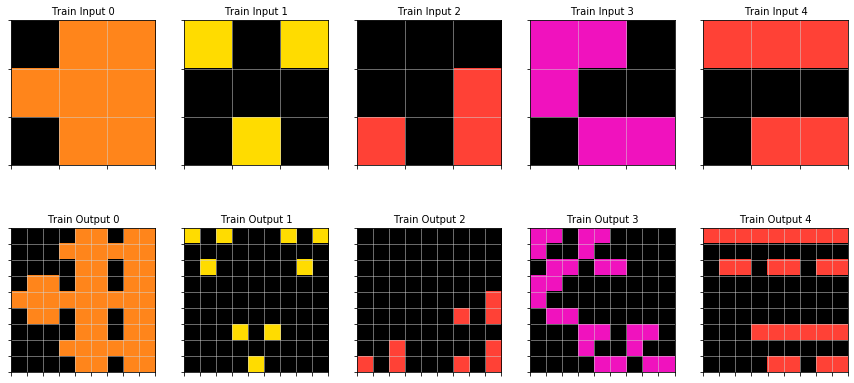

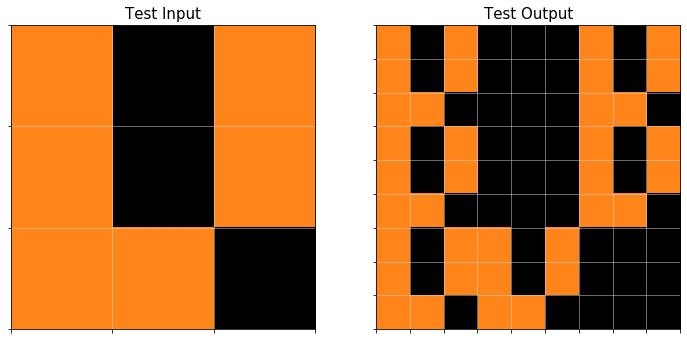

In [6]:
training_tasks = training_path.glob('**/*.json')

sample_task = next(training_tasks)
sample_task_str = str(sample_task)
print(sample_task_str + '\n')

with open(sample_task_str, 'r') as f:
    task = json.load(f)
        
    # show structure of data
    print(prettyjson(task, indent=2, maxlinelength=60))
    
    train = task['train']
    test = task['test']

    cmap = colors.ListedColormap(
       ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)

    plot_task_pairs(train, 'Train')
    plot_task_pairs(test, 'Test')

Next, we will create a dataframe describing the dataset as a whole. The dataframe will have the following columns: 

- task label 
- number of training images 
- training input image widths
- training input image heights 
- training output image widths
- training output image heights
- testing input image widths
- testing input image heights 
- testing output image widths
- testing output image heights
- unique values(colors) in each set

In [7]:
def find_unique_colors(task_set, unique_list): 
    for task in task_set:
        for io_set in task.values(): 
            result = set(x for l in io_set for x in l)
            
            for val in result: 
                if val not in unique_list:
                    unique_list.append(val)
                    
def calculate_widths_and_heights(task_set):
    num_set = len(task_set)
    
    input_widths = []
    input_heights = []
    output_widths = []
    output_heights = []
    
    for i in range(num_set):
        task_input = task_set[i]['input']
        task_output = task_set[i]['output']
        
        task_input_width = len(task_input[0])
        task_input_height = len(task_input)
        
        task_output_width = len(task_output[0])
        task_output_height = len(task_output)
        
        input_widths.append(task_input_width)
        input_heights.append(task_input_height)
        output_widths.append(task_output_width)
        output_heights.append(task_output_height)
        
    return (input_widths, input_heights, output_widths, output_heights)

In [8]:
training_task_paths = training_path.glob('**/*.json')

data = {
    'task_label': [], 
    'num_train': [], 
    'train_input_widths': [],
    'train_input_heights': [],
    'train_output_widths': [], 
    'train_output_heights': [],
    'test_input_width': [], 
    'test_input_height': [], 
    'test_output_width': [], 
    'test_output_height': [], 
    'unique_colors': [], 
}

for path in training_task_paths:
    task_path_str = str(path)
                              
    with open(task_path_str, 'r') as f:
        task = json.load(f)
        
    train = task['train']
    test = task['test']
    
    num_train = len(train)

    train_input_widths, train_input_heights, \
    train_output_widths, train_output_heights = calculate_widths_and_heights(train)

    # calculate test input and output dimensions
    test_input_widths, test_input_heights, \
    test_output_widths, test_output_heights = calculate_widths_and_heights(test)
    
    # calculate grid colors 
    unique_colors = []
    find_unique_colors(train, unique_colors)
    find_unique_colors(test, unique_colors)
    
    # populate data
    data['task_label'].append(task_path_str.split("\\")[-1]) 
    data['num_train'].append(num_train)
    data['train_input_widths'].append(train_input_widths)
    data['train_input_heights'].append(train_input_heights)
    data['train_output_widths'].append(train_output_widths)
    data['train_output_heights'].append(train_output_heights)
    data['test_input_width'].append(test_input_widths)
    data['test_input_height'].append(test_input_heights)
    data['test_output_width'].append(test_output_widths)
    data['test_output_height'].append(test_output_heights) 
    data['unique_colors'].append(sorted(unique_colors))
    
task_summary_df = pd.DataFrame.from_dict(data)
task_summary_df.head()

,task_label,num_train,train_input_widths,train_input_heights,train_output_widths,train_output_heights,test_input_width,test_input_height,test_output_width,test_output_height,unique_colors
0,007bbfb7.json,5,"[3, 3, 3, 3, 3]","[3, 3, 3, 3, 3]","[9, 9, 9, 9, 9]","[9, 9, 9, 9, 9]",[3],[3],[9],[9],"[0, 2, 4, 6, 7]"
1,00d62c1b.json,5,"[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]",[20],[20],[20],[20],"[0, 3, 4]"
2,017c7c7b.json,3,"[3, 3, 3]","[6, 6, 6]","[3, 3, 3]","[9, 9, 9]",[3],[6],[3],[9],"[0, 1, 2]"
3,025d127b.json,2,"[9, 9]","[14, 8]","[9, 9]","[14, 8]",[10],[10],[10],[10],"[0, 2, 4, 6, 8]"
4,045e512c.json,3,"[21, 21, 21]","[21, 21, 21]","[21, 21, 21]","[21, 21, 21]",[21],[21],[21],[21],"[0, 1, 2, 3, 4, 5, 6, 8]"


In [9]:
# Write summary data frame to csv file to be used in future notebooks
task_summary_df.to_csv('../Data/task_summary.csv', index=False)

# verify file creation
pd.read_csv('../Data/task_summary.csv')

,task_label,num_train,train_input_widths,train_input_heights,train_output_widths,train_output_heights,test_input_width,test_input_height,test_output_width,test_output_height,unique_colors
0,007bbfb7.json,5,"[3, 3, 3, 3, 3]","[3, 3, 3, 3, 3]","[9, 9, 9, 9, 9]","[9, 9, 9, 9, 9]",[3],[3],[9],[9],"[0, 2, 4, 6, 7]"
1,00d62c1b.json,5,"[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]","[6, 10, 10, 10, 20]",[20],[20],[20],[20],"[0, 3, 4]"
2,017c7c7b.json,3,"[3, 3, 3]","[6, 6, 6]","[3, 3, 3]","[9, 9, 9]",[3],[6],[3],[9],"[0, 1, 2]"
3,025d127b.json,2,"[9, 9]","[14, 8]","[9, 9]","[14, 8]",[10],[10],[10],[10],"[0, 2, 4, 6, 8]"
4,045e512c.json,3,"[21, 21, 21]","[21, 21, 21]","[21, 21, 21]","[21, 21, 21]",[21],[21],[21],[21],"[0, 1, 2, 3, 4, 5, 6, 8]"
...,...,...,...,...,...,...,...,...,...,...,...
395,fcb5c309.json,3,"[13, 16, 16]","[13, 13, 15]","[7, 7, 7]","[7, 6, 7]",[17],[17],[8],[8],"[0, 1, 2, 3, 4, 8]"
396,fcc82909.json,3,"[10, 10, 10]","[10, 10, 10]","[10, 10, 10]","[10, 10, 10]",[10],[10],[10],[10],"[0, 1, 2, 3, 4, 6, 7, 8, 9]"
397,feca6190.json,5,"[5, 5, 5, 5, 5]","[1, 1, 1, 1, 1]","[10, 5, 15, 15, 5]","[10, 5, 15, 15, 5]",[5],[1],[20],[20],"[0, 1, 2, 4, 6, 7, 8, 9]"
398,ff28f65a.json,8,"[5, 5, 7, 6, 3, 7, 7, 7]","[5, 5, 7, 6, 3, 7, 7, 7]","[3, 3, 3, 3, 3, 3, 3, 3]","[3, 3, 3, 3, 3, 3, 3, 3]","[6, 7, 7]","[6, 7, 7]","[3, 3, 3]","[3, 3, 3]","[0, 1, 2]"
